In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [3]:
start_dt = '2021-06-16'
end_dt = '2021-07-18'


* Which campaigns saw the biggest drops in IR

* Filter for spike in APK failures

* 

In [5]:
df_stats = bigquery_client.query(f"""
select
    date 
    , extract(date from r.etimestamp) as edate
    , extract(hour from r.timestamp) as hour 
    , extract(hour from r.etimestamp) as ehour 
    , c.name as campaign_name
    , r.ssb_campaign_uuid 
    , p.name as sponsored_app_name
    , p.bundle as sponsored_bnd
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(case when event_type = 'install' then revenue else 0 end) as revenue
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
from stats.rows1 r
join metadata.dt_campaigns c
    on r.ssb_campaign_uuid = c.uuid
join metadata.apps p
    on r.sponsored_app_id = p.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
group by 1,2,3,4,5,6,7,8
""").to_dataframe()
df_stats

date       edate  hour  ehour  \
0        2021-07-07  2021-07-07    15     18   
1        2021-07-07  2021-07-07     1     13   
2        2021-07-07  2021-07-07     9     17   
3        2021-07-07  2021-07-07    15     17   
4        2021-07-07  2021-07-07     8      8   
...             ...         ...   ...    ...   
1969903  2021-06-18  2021-06-18     7     15   
1969904  2021-06-18  2021-06-20    17     22   
1969905  2021-06-28  2021-06-28    15     17   
1969906  2021-06-28  2021-06-29    15      2   
1969907  2021-06-28  2021-06-29     5      7   

                                             campaign_name  \
0                   Blind Ferret - Rewarded Play - US - UA   
1                             Android-Twitter-Twitter-CA-4   
2                   Blind Ferret - Rewarded Play - US - UA   
3                    Opera News - Opera News - US - UA ATT   
4                           TikTok - TikTok - MX - True GP   
...                                                    ...   
1969903  Particle Media – News Break – US – All – GP - ...   
1969904  Particle Media – News Break – US – All – GP - ...   
1969905  Particle Media – News Break – US – All – GP - ...   
1969906  Particle Media – News Break – US – All – GP - ...   
1969907  Particle Media – News Break – US – All – GP - ...   

                        ssb_campaign_uuid  \
0        ebaef6f00019bc072cae96b5052f62d2   
1        741b622cf9f7b2e747451ae925d01e9c   
2        ebaef6f00019bc072cae96b5052f62d2   
3        2da0b609215635e899c59e7a302a2f28   
4        9c7180192abd80a0cd4d15440e04ac55   
...                                   ...   
1969903  16d935fca4ea8b4dffa296ba147ec7df   
1969904  16d935fca4ea8b4dffa296ba147ec7df   
1969905  16d935fca4ea8b4dffa296ba147ec7df   
1969906  16d935fca4ea8b4dffa296ba147ec7df   
1969907  16d935fca4ea8b4dffa296ba147ec7df   

                                        sponsored_app_name  \
0        Rewarded Play: Earn Free Gift Cards & Play Games!   
1                                                  Twitter   
2        Rewarded Play: Earn Free Gift Cards & Play Games!   
3                Opera News: Breaking Local & US Headlines   
4                                                   TikTok   
...                                                    ...   
1969903  NewsBreak: Local News that Connects the Community   
1969904  NewsBreak: Local News that Connects the Community   
1969905  NewsBreak: Local News that Connects the Community   
1969906  NewsBreak: Local News that Connects the Community   
1969907  NewsBreak: Local News that Connects the Community   

                      sponsored_bnd  impressions  clicks  installs  spend  \
0        com.affinity.rewarded_play            3       1         1   2.75   
1               com.twitter.android            4       1         0   0.00   
2        com.affinity.rewarded_play            1       0         0   0.00   
3                com.opera.app.news            3       2         0   0.00   
4          com.zhiliaoapp.musically         1258      14         0   0.00   
...                             ...          ...     ...       ...    ...   
1969903  com.particlenews.newsbreak            2       1         0   0.00   
1969904  com.particlenews.newsbreak            0       1         0   0.00   
1969905  com.particlenews.newsbreak          109      21         1   3.00   
1969906  com.particlenews.newsbreak            4       1         0   0.00   
1969907  com.particlenews.newsbreak            0      18         0   0.00   

             cost  
0        0.151715  
1        0.003768  
2        0.018340  
3        0.056173  
4        0.156117  
...           ...  
1969903  0.000660  
1969904  0.000000  
1969905  0.645754  
1969906  0.005028  
1969907  0.000000  

[1969908 rows x 13 columns]

In [87]:
def calc_metrics(df, sov_base = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['media_cost'] = 1.25*df['cost']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['media_cost']/df['impressions']
    df['rpi'] = df['revenue']/df['installs']
    df['margin'] = 100*(df['revenue']-df['cost'])/df['revenue']

    if sov_base == 0:
        df['media_cost_sov'] = 100*df['media_cost']/df['media_cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        df['total_media_cost'] = df['cost'].sum()
    else:
        df['media_cost_sov'] = 100*df['media_cost']/df.groupby(sov_base)['media_cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(sov_base)['revenue'].transform(sum)
        df['total_media_cost'] = df.groupby(sov_base)['cost'].transform(sum)
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','revenue','revenue_sov','media_cost','media_cost_sov','margin','total_media_cost']]

In [334]:
pivot = df_stats[df_stats.sponsored_bnd == 'com.affinity.rewarded_play'].pivot_table(values = ['impressions','clicks','installs','revenue','cost'], index = 'date', aggfunc = np.sum)
format_pivot = calc_metrics(pivot,0)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','revenue_sov','media_cost_sov'])

In [89]:
df_07 = df_stats.loc[df_stats.date == datetime.date(2021,7,7)]
df_08 = df_stats.loc[df_stats.date == datetime.date(2021,7,8)]
df_09 = df_stats.loc[df_stats.date == datetime.date(2021,7,9)]
join_index = ['hour','campaign_name','ssb_campaign_uuid','sponsored_app_name','sponsored_bnd']
cols = ['impressions','clicks','installs']
dod_hr_7_8 = df_07.set_index(join_index)[cols].join(df_08.set_index(join_index)[cols], lsuffix = '_7', rsuffix = '_8')
hr_to_9 = (df_07.hour <= df_09.hour.max())
dod_hr_7_9 = df_07.loc[hr_to_9].set_index(join_index)[cols].join(df_09.set_index(join_index)[cols], lsuffix = '_7', rsuffix = '_9')

dod_hr_7_8_9 = dod_hr_7_8.join(df_09.set_index(join_index)[cols], lsuffix = '', rsuffix = '_9')
dod_hr_7_8_9.columns = dod_hr_7_8_9.columns[:-3].tolist() + ['impressions_9','clicks_9','installs_9']
dod_hr_7_8_9

impressions_7  \
hour campaign_name                     ssb_campaign_uuid                sponsored_app_name       sponsored_bnd                        
0    Android-Door Dash-Door Dash-US- 4 bcbabfd8e040a2e6f0be87759e1886ee DoorDash - Food Delivery com.dd.doordash                  1   
                                                                                                 com.dd.doordash                  1   
                                                                                                 com.dd.doordash                  1   
                                                                                                 com.dd.doordash                  1   
                                                                                                 com.dd.doordash                  1   
...                                                                                                                             ...   
23   Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0 Twitter                  com.twitter.android              0   
                                                                                                 com.twitter.android              0   
                                                                                                 com.twitter.android              0   
                                                                                                 com.twitter.android              0   
                                                                                                 com.twitter.android              0   

                                                                                                                      clicks_7  \
hour campaign_name                     ssb_campaign_uuid                sponsored_app_name       sponsored_bnd                   
0    Android-Door Dash-Door Dash-US- 4 bcbabfd8e040a2e6f0be87759e1886ee DoorDash - Food Delivery com.dd.doordash             0   
                                                                                                 com.dd.doordash             0   
                                                                                                 com.dd.doordash             0   
                                                                                                 com.dd.doordash             0   
                                                                                                 com.dd.doordash             0   
...                                                                                                                        ...   
23   Twitter - Twitter - BR - True GP  b7c89cdb901658c9b5cde8b89203d0f0 Twitter                  com.twitter.android         0   
                                                                                                 com.twitter.android         0   
                                                                                                 com.twitter.android         0   
                                                                                                 com.twitter.android         0   
                                                                                                 com.twitter.android         0   

                                                                                                                      installs_7  \
hour campaign_name                     ssb_campaign_uuid                sponsored_app_name       sponsored_bnd                     
0    Android-Door Dash-Door Dash-US- 4 bcbabfd8e040a2e6f0be87759e1886ee DoorDash - Food Delivery com.dd.doordash               0   
                                                                                                 com.dd.doordash               0   
                                                                                                 com.dd.doordash               0   
           

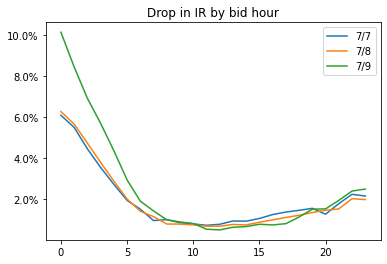

In [90]:
by_hr = dod_hr_7_8_9.groupby('hour').sum()
by_hr['ir_7'] = by_hr['installs_7']/by_hr['clicks_7']
by_hr['ir_8'] = by_hr['installs_8']/by_hr['clicks_8']
by_hr['ir_9'] = by_hr['installs_9']/by_hr['clicks_9']
by_hr['ctr_7'] = by_hr['clicks_7']/by_hr['impressions_7']
by_hr['ctr_8'] = by_hr['clicks_8']/by_hr['impressions_8']
by_hr['ctr_9'] = by_hr['clicks_9']/by_hr['impressions_9']
plt.plot(100*by_hr[['ir_7','ir_8','ir_9']])
plt.title('Drop in IR by bid hour')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['7/7','7/8','7/9'])

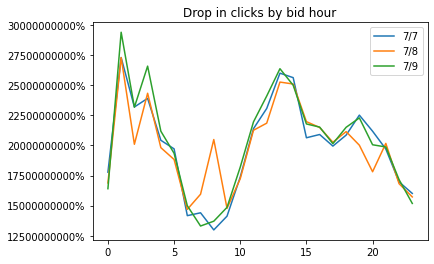

In [91]:
plt.plot(100*by_hr[['clicks_7','clicks_8','clicks_9']])
plt.title('Drop in clicks by bid hour')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['7/7','7/8','7/9'])

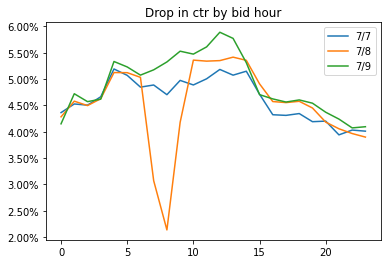

In [92]:
plt.plot(100*by_hr[['ctr_7','ctr_8','ctr_9']])
plt.title('Drop in ctr by bid hour')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['7/7','7/8','7/9'])

# Quantifying drop in missed revenue

In [93]:
# select 
#     date(e.receivedtimestamp) as edate
#     , hour(e.receivedtimestamp) as ehour
#     , e.triggersource
#     , e.eventstring
#     , e.failure
#     , e.packagename
#     , count(distinct case when eventcode = 490 then e.advertisingid else NULL end) as install_success
#     , count(distinct case when eventcode = 470 then e.advertisingid else NULL end) as install_failures
# from lakehouse.uevents_us_west_1 e
# where date(e.receivedtimestamp) >= '2021-06-16'
# and date(e.receivedtimestamp) <= '2021-07-18'
# and e.triggersource = 'delivers'
# and e.siteid = 12605
# and (e.eventcode = 490 
# or e.failure in ('INSTALL_FAILED_VERIFICATION_FAILURE','ERROR_INSTALL:-22'))
# and e.year = 2021
# and e.month >= 06
# and e.month <= 07
# group by 1,2,3,4,5,6

In [311]:
failures = pd.read_csv('files/Failures_6.16_7.18.csv')
failures.columns = ['edate','ehour','sponsored_bnd','install_success','install_failure']
failures['sponsored_bnd'] = failures.sponsored_bnd.str.lower()
failures['edate'] = pd.to_datetime(failures.edate)
df_stats['edate'] = pd.to_datetime(df_stats.edate)
df = df_stats.groupby(['edate','ehour','sponsored_bnd'])['installs','revenue'].sum().join(failures.set_index(['edate','ehour','sponsored_bnd']), how = 'left').reset_index()
df[['installs','revenue','install_success','install_failure']] = df[['installs','revenue','install_success','install_failure']].fillna(0)
df['failure_rate'] = 100*df.install_failure/(np.maximum(1,df.install_success) + df.install_failure)
df

<ipython-input-311-d502ab8e33e7>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df_stats.groupby(['edate','ehour','sponsored_bnd'])['installs','revenue'].sum().join(failures.set_index(['edate','ehour','sponsored_bnd']), how = 'left').reset_index()


edate  ehour           sponsored_bnd  installs  revenue  \
0     2021-06-16      0              1132762804         0     0.00   
1     2021-06-16      0               284035177         5    20.00   
2     2021-06-16      0        co.triller.droid        21    10.50   
3     2021-06-16      0   com.contextlogic.wish        10    20.00   
4     2021-06-16      0         com.dd.doordash        32   102.00   
...          ...    ...                     ...       ...      ...   
26806 2021-08-01      8  de.cellular.ottohybrid         1     6.50   
26807 2021-08-01     10         com.dd.doordash         1     6.00   
26808 2021-08-01     19               284035177         1     4.75   
26809 2021-08-01     20     com.twitter.android         1     2.25   
26810 2021-08-01     21         com.dd.doordash         1     8.00   

       install_success  install_failure  failure_rate  
0                  0.0              0.0           0.0  
1                  0.0              0.0           0.0  
2                122.0              0.0           0.0  
3                 67.0              0.0           0.0  
4                184.0              0.0           0.0  
...                ...              ...           ...  
26806              0.0              0.0           0.0  
26807              0.0              0.0           0.0  
26808              0.0              0.0           0.0  
26809              0.0              0.0           0.0  
26810              0.0              0.0           0.0  

[26811 rows x 8 columns]

In [312]:
pivot = df[df.edate == '2021-07-07'].pivot_table(values = ['install_failure','install_success','installs'], index = 'ehour', aggfunc = np.sum)
pivot['failure_rate'] = 100*pivot.install_failure/(pivot.install_failure+pivot.install_success)
pivot

install_failure  install_success  installs  failure_rate
ehour                                                          
0                  0.0           6426.0      3847      0.000000
1                  0.0           7264.0      4085      0.000000
2                  0.0           9656.0      4626      0.000000
3                  0.0           8957.0      3890      0.000000
4                  0.0           6225.0      3052      0.000000
5                  0.0           4610.0      2246      0.000000
6                  0.0           3207.0      1682      0.000000
7                  0.0           2326.0      1311      0.000000
8                  0.0           1570.0      1098      0.000000
9                  1.0           1457.0      1155      0.068587
10                 0.0           1791.0      1392      0.000000
11                 1.0           2281.0      1792      0.043821
12                 0.0           3246.0      2303      0.000000
13                 0.0           4063.0      2750      0.000000
14                 0.0           4627.0      3003      0.000000
15                 0.0           4542.0      3171      0.000000
16                 0.0           4988.0      3444      0.000000
17                 1.0           5400.0      3674      0.018515
18                 0.0           5547.0      3541      0.000000
19                 1.0           5895.0      3622      0.016961
20              1177.0           5129.0      3361     18.664764
21              1464.0           5413.0      3733     21.288352
22              1530.0           5160.0      3561     22.869955
23              1642.0           4904.0      3777     25.084021

In [313]:
pivot = df[(df.edate <= '2021-07-06') | ((df.edate == '2021-07-07') & (df.ehour < 20))].pivot_table(values = ['install_failure','install_success','installs'], index = 'sponsored_bnd', aggfunc = np.sum)
pivot['failure_rate'] = 100*pivot.install_failure/(pivot.install_failure+pivot.install_success)
pivot.style.format('{:,.0f}').format({'failure_rate':'{:,.2f}%'})

normal failure rate was < 0.1%. practically we will count all failures during the bug as missed installation opportunities.

In [314]:
# reset previous iterations
df = df[df.columns.tolist()[:8]]

bug_start = df[(df.failure_rate >= 1) & (df.install_failure >= 5) & (df.edate >= pd.to_datetime('2021-07-07'))].pivot_table(values = ['edate'], index = 'sponsored_bnd', aggfunc = min)
bug_start.columns = ['bug_start_dt']
bug_start_hr = df[(df.failure_rate >= 1) & (df.install_failure >= 5) & (df.edate >= pd.to_datetime('2021-07-07'))].pivot_table(values = ['ehour'], index = ['sponsored_bnd','edate'], aggfunc = min).reset_index()
bug_start_hr.columns = ['sponsored_bnd','bug_start_dt','bug_start_hr']
bug_start = pd.merge(bug_start, bug_start_hr, on = ['sponsored_bnd','bug_start_dt'])

df = pd.merge(df, bug_start, on = 'sponsored_bnd', how = 'left')
df

edate  ehour           sponsored_bnd  installs  revenue  \
0     2021-06-16      0              1132762804         0     0.00   
1     2021-06-16      0               284035177         5    20.00   
2     2021-06-16      0        co.triller.droid        21    10.50   
3     2021-06-16      0   com.contextlogic.wish        10    20.00   
4     2021-06-16      0         com.dd.doordash        32   102.00   
...          ...    ...                     ...       ...      ...   
26806 2021-08-01      8  de.cellular.ottohybrid         1     6.50   
26807 2021-08-01     10         com.dd.doordash         1     6.00   
26808 2021-08-01     19               284035177         1     4.75   
26809 2021-08-01     20     com.twitter.android         1     2.25   
26810 2021-08-01     21         com.dd.doordash         1     8.00   

       install_success  install_failure  failure_rate bug_start_dt  \
0                  0.0              0.0           0.0          NaT   
1                  0.0              0.0           0.0          NaT   
2                122.0              0.0           0.0          NaT   
3                 67.0              0.0           0.0          NaT   
4                184.0              0.0           0.0          NaT   
...                ...              ...           ...          ...   
26806              0.0              0.0           0.0          NaT   
26807              0.0              0.0           0.0          NaT   
26808              0.0              0.0           0.0          NaT   
26809              0.0              0.0           0.0   2021-07-07   
26810              0.0              0.0           0.0          NaT   

       bug_start_hr  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
26806           NaN  
26807           NaN  
26808           NaN  
26809          20.0  
26810           NaN  

[26811 rows x 10 columns]

In [315]:
bug_end = df[((df.failure_rate <= .1)|((df.install_failure<3)&(df.install_success>=15))) & (df.install_success>=10) & (df.edate >= pd.to_datetime('2021-07-09')) & (df.sponsored_bnd.isin(bug_start.sponsored_bnd.tolist()))].pivot_table(values = ['edate'], index = 'sponsored_bnd', aggfunc = min)
bug_end.columns = ['bug_end_dt']
bug_end_hr = df[((df.failure_rate <= .1)|((df.install_failure<3)&(df.install_success>=15))) & (df.install_success >= 10) & (df.edate >= pd.to_datetime('2021-07-09')) & (df.sponsored_bnd.isin(bug_end.index.tolist()))].pivot_table(values = ['ehour'], index = ['sponsored_bnd','edate'], aggfunc = min).reset_index()
bug_end_hr.columns = ['sponsored_bnd','bug_end_dt','bug_end_hr']
bug_end_hr[bug_end_hr.bug_end_dt.isin(['2021-07-09','2021-07-10','2021-07-11'])]

bug_end = pd.merge(bug_end, bug_end_hr, on = ['sponsored_bnd','bug_end_dt'])
df = pd.merge(df, bug_end, on = ['sponsored_bnd'], how = 'left')
df

edate  ehour           sponsored_bnd  installs  revenue  \
0     2021-06-16      0              1132762804         0     0.00   
1     2021-06-16      0               284035177         5    20.00   
2     2021-06-16      0        co.triller.droid        21    10.50   
3     2021-06-16      0   com.contextlogic.wish        10    20.00   
4     2021-06-16      0         com.dd.doordash        32   102.00   
...          ...    ...                     ...       ...      ...   
26806 2021-08-01      8  de.cellular.ottohybrid         1     6.50   
26807 2021-08-01     10         com.dd.doordash         1     6.00   
26808 2021-08-01     19               284035177         1     4.75   
26809 2021-08-01     20     com.twitter.android         1     2.25   
26810 2021-08-01     21         com.dd.doordash         1     8.00   

       install_success  install_failure  failure_rate bug_start_dt  \
0                  0.0              0.0           0.0          NaT   
1                  0.0              0.0           0.0          NaT   
2                122.0              0.0           0.0          NaT   
3                 67.0              0.0           0.0          NaT   
4                184.0              0.0           0.0          NaT   
...                ...              ...           ...          ...   
26806              0.0              0.0           0.0          NaT   
26807              0.0              0.0           0.0          NaT   
26808              0.0              0.0           0.0          NaT   
26809              0.0              0.0           0.0   2021-07-07   
26810              0.0              0.0           0.0          NaT   

       bug_start_hr bug_end_dt  bug_end_hr  
0               NaN        NaT         NaN  
1               NaN        NaT         NaN  
2               NaN        NaT         NaN  
3               NaN        NaT         NaN  
4               NaN        NaT         NaN  
...             ...        ...         ...  
26806           NaN        NaT         NaN  
26807           NaN        NaT         NaN  
26808           NaN        NaT         NaN  
26809          20.0 2021-07-10         6.0  
26810           NaN        NaT         NaN  

[26811 rows x 12 columns]

In [332]:
bug_start

sponsored_bnd bug_start_dt  bug_start_hr
0  com.affinity.rewarded_play   2021-07-08             2
1              com.kwai.video   2021-07-07            21
2           com.ripio.android   2021-07-07            22
3         com.twitter.android   2021-07-07            20
4  jp.gocro.smartnews.android   2021-07-07            20

In [333]:
bug_end

sponsored_bnd bug_end_dt  bug_end_hr
0  com.affinity.rewarded_play 2021-07-11           2
1              com.kwai.video 2021-07-13           0
2           com.ripio.android 2021-07-11           0
3         com.twitter.android 2021-07-10           6
4  jp.gocro.smartnews.android 2021-07-10           8

In [316]:
df['bug'] = df.apply(lambda x:True if (x.edate > x.bug_start_dt and x.edate < x.bug_end_dt) 
                     or (x.edate == x.bug_start_dt and x.ehour >= x.bug_start_hr)
                    or (x.edate == x.bug_end_dt and x.ehour <= x.bug_end_hr) else False, axis = 1)
df['rpi'] = df.revenue/df.installs
df['dow'] = df.edate.dt.dayofweek

df['install_total'] = df.groupby(['sponsored_bnd','ehour','dow'])['installs'].cumsum()
df['install_total'] = df.groupby(['sponsored_bnd','ehour','dow'])['install_total'].shift(1)
df['install_success_total'] = df.groupby(['sponsored_bnd','ehour','dow'])['install_success'].cumsum()
df['install_success_total'] = df.groupby(['sponsored_bnd','ehour','dow'])['install_success_total'].shift(1)
df['install_success_total'] = np.where(df['install_success_total']==0,1,df['install_success_total'])
df['missed_revenue'] = np.where(df.bug, df.rpi*(df.install_total/df.install_success_total)*df.install_failure, 0)
df.loc[df.bug, ['edate','ehour','sponsored_bnd','installs','install_success','install_failure','install_total','install_success_total','missed_revenue']].sort_values('install_failure', ascending = False).head(30)

edate  ehour               sponsored_bnd  installs  \
16554 2021-07-08      3  jp.gocro.smartnews.android       951   
16496 2021-07-08      1  jp.gocro.smartnews.android      1071   
16525 2021-07-08      2  jp.gocro.smartnews.android       878   
16467 2021-07-08      0  jp.gocro.smartnews.android       922   
16547 2021-07-08      3         com.twitter.android       318   
16583 2021-07-08      4  jp.gocro.smartnews.android       736   
17096 2021-07-08     22         com.twitter.android       220   
17124 2021-07-08     23         com.twitter.android       234   
16988 2021-07-08     18  jp.gocro.smartnews.android       835   
16960 2021-07-08     17  jp.gocro.smartnews.android       811   
16931 2021-07-08     16  jp.gocro.smartnews.android       758   
17017 2021-07-08     19  jp.gocro.smartnews.android       811   
17067 2021-07-08     21         com.twitter.android       202   
16576 2021-07-08      4         com.twitter.android       286   
17211 2021-07-09      2         com.twitter.android       248   
16902 2021-07-08     15  jp.gocro.smartnews.android       754   
17045 2021-07-08     20  jp.gocro.smartnews.android       769   
17182 2021-07-09      1         com.twitter.android       234   
16489 2021-07-08      1         com.twitter.android       320   
16981 2021-07-08     18         com.twitter.android       238   
16438 2021-07-07     23  jp.gocro.smartnews.android      1011   
16873 2021-07-08     14  jp.gocro.smartnews.android       590   
16402 2021-07-07     22         com.twitter.android       274   
16612 2021-07-08      5  jp.gocro.smartnews.android       556   
16953 2021-07-08     17         com.twitter.android       271   
16518 2021-07-08      2         com.twitter.android       322   
17010 2021-07-08     19         com.twitter.android       230   
16431 2021-07-07     23         com.twitter.android       328   
16844 2021-07-08     13  jp.gocro.smartnews.android       499   
16373 2021-07-07     21         com.twitter.android       319   

       install_success  install_failure  install_total  install_success_total  \
16554            397.0           1554.0         2877.0                 3815.0   
16496            372.0           1347.0         3352.0                 3584.0   
16525            349.0           1257.0         3196.0                 4156.0   
16467            314.0           1219.0         2650.0                 2675.0   
16547            830.0           1131.0         1254.0                 3393.0   
16583            303.0           1125.0         2199.0                 2701.0   
17096            605.0           1044.0         1109.0                 3095.0   
17124            625.0           1035.0         1150.0                 3191.0   
16988            309.0           1026.0         2367.0                 2038.0   
16960            305.0           1020.0         2354.0                 2381.0   
16931            317.0            995.0         2398.0                 2542.0   
17017            300.0            984.0         2322.0                 2009.0   
17067            577.0            934.0         1064.0                 2895.0   
16576            707.0            931.0         1025.0                 2610.0   
17211            631.0            917.0         1246.0                 3449.0   
16902            279.0            908.0         2127.0                 2284.0   
17045            285.0            897.0         2500.0                 2118.0   
17182            616.0            892.0         1279.0                 3466.0   
16489            727.0            883.0         1094.0                 3408.0   
16981            583.0            849.0         1147.0                 2621.0   
16438            319.0            837.0         2514.0                 1814.0   
16873            212.0            832.0         2047.0                 2170.0   
16402            750.0            815.0         1063.0                 2988.0   
16612            266.0            809.0         167

In [317]:
df[df.bug].groupby('sponsored_bnd')['missed_revenue'].sum()

sponsored_bnd
com.affinity.rewarded_play     2331.784441
com.kwai.video                15147.008969
com.ripio.android              3512.119284
com.twitter.android           28826.295366
jp.gocro.smartnews.android    36541.896029
Name: missed_revenue, dtype: float64

In [318]:
df[(df.sponsored_bnd == 'jp.gocro.smartnews.android')].pivot_table(values = ['installs','install_failure','install_success','failure_rate','revenue'], index = ['edate','bug'], aggfunc = np.sum).head(30)

failure_rate  install_failure  install_success  installs  \
edate      bug                                                               
2021-06-16 False      0.145773              1.0          13973.0     12680   
2021-06-17 False      0.000000              0.0          15763.0     14727   
2021-06-18 False      0.000000              0.0          18456.0     15432   
2021-06-19 False      0.310394              3.0          20860.0     18146   
2021-06-20 False      0.000000              0.0          20594.0     18000   
2021-06-21 False      0.103413              1.0          19528.0     16608   
2021-06-22 False      0.000000              0.0          18571.0     17025   
2021-06-23 False      0.269148              3.0          18545.0     17178   
2021-06-24 False      0.000000              0.0          16534.0     16806   
2021-06-25 False      0.000000              0.0          14354.0     14659   
2021-06-26 False      0.000000              0.0          15615.0     16768   
2021-06-27 False      0.185874              1.0          15710.0     17102   
2021-06-28 False      0.158730              1.0          16333.0     16205   
2021-06-29 False      0.268097              1.0          18677.0     16402   
2021-06-30 False      0.126103              1.0          18408.0     16412   
2021-07-01 False      0.000000              0.0          19604.0     17325   
2021-07-02 False      0.225775              2.0          21796.0     18928   
2021-07-03 False      0.345544              4.0          21564.0     18513   
2021-07-04 False      0.093023              2.0          20859.0     18150   
2021-07-05 False      0.160696              2.0          20802.0     17803   
2021-07-06 False      0.000000              0.0          20254.0     17457   
2021-07-07 False      0.000000              0.0          16934.0     14051   
           True     255.430661           2852.0           1623.0      3725   
2021-07-08 True    1826.020972          18730.0           5393.0     13956   
2021-07-09 True     762.116490            449.0           7620.0      7422   
2021-07-10 False     15.785663            128.0          12495.0     11344   
           True       7.925007             83.0           8894.0      6645   
2021-07-11 False     13.880506            130.0          21290.0     18337   
2021-07-12 False     11.432819            104.0          21218.0     18159   
2021-07-13 False      8.898000             83.0          21370.0     18348   

                  revenue  
edate      bug             
2021-06-16 False  21555.6  
2021-06-17 False  25034.9  
2021-06-18 False  26231.6  
2021-06-19 False  30845.4  
2021-06-20 False  30596.6  
2021-06-21 False  28229.2  
2021-06-22 False  28935.7  
2021-06-23 False  29192.4  
2021-06-24 False  28562.8  
2021-06-25 False  24915.3  
2021-06-26 False  28497.1  
2021-06-27 False  29069.0  
2021-06-28 False  27542.3  
2021-06-29 False  27878.2  
2021-06-30 False  27894.2  
2021-07-01 False  29445.5  
2021-07-02 False  32172.0  
2021-07-03 False  31466.3  
2021-07-04 False  30848.8  
2021-07-05 False  30256.8  
2021-07-06 False  29670.0  
2021-07-07 False  23881.5  
           True    6329.9  
2021-07-08 True   23717.0  
2021-07-09 True   12613.0  
2021-07-10 False  19280.6  
           True   11293.7  
2021-07-11 False  31167.9  
2021-07-12 False  30865.1  
2021-07-13 False  31183.6

In [331]:
filters = (df.sponsored_bnd == 'jp.gocro.smartnews.android') & (df.edate.isin([pd.to_datetime('2021-07-07'),pd.to_datetime('2021-07-10')]))
df[filters]#.pivot_table(values = ['installs','install_failure','install_success','failure_rate','revenue'], index = ['edate','ehour','bug','bug_start_dt'], aggfunc = np.sum).head(30)

edate  ehour               sponsored_bnd  installs  revenue  \
15770 2021-07-07      0  jp.gocro.smartnews.android       928   1577.6   
15799 2021-07-07      1  jp.gocro.smartnews.android      1062   1805.2   
15829 2021-07-07      2  jp.gocro.smartnews.android      1245   2115.5   
15858 2021-07-07      3  jp.gocro.smartnews.android      1007   1711.7   
15888 2021-07-07      4  jp.gocro.smartnews.android       820   1393.8   
15918 2021-07-07      5  jp.gocro.smartnews.android       589   1001.1   
15946 2021-07-07      6  jp.gocro.smartnews.android       460    781.6   
15975 2021-07-07      7  jp.gocro.smartnews.android       342    581.0   
16004 2021-07-07      8  jp.gocro.smartnews.android       261    443.1   
16033 2021-07-07      9  jp.gocro.smartnews.android       261    443.7   
16062 2021-07-07     10  jp.gocro.smartnews.android       308    523.6   
16090 2021-07-07     11  jp.gocro.smartnews.android       447    759.5   
16119 2021-07-07     12  jp.gocro.smartnews.android       593   1007.9   
16148 2021-07-07     13  jp.gocro.smartnews.android       667   1133.9   
16177 2021-07-07     14  jp.gocro.smartnews.android       696   1183.0   
16206 2021-07-07     15  jp.gocro.smartnews.android       741   1259.1   
16235 2021-07-07     16  jp.gocro.smartnews.android       839   1426.1   
16264 2021-07-07     17  jp.gocro.smartnews.android       926   1574.0   
16293 2021-07-07     18  jp.gocro.smartnews.android       913   1552.1   
16322 2021-07-07     19  jp.gocro.smartnews.android       946   1608.0   
16351 2021-07-07     20  jp.gocro.smartnews.android       850   1444.6   
16380 2021-07-07     21  jp.gocro.smartnews.android       887   1506.5   
16409 2021-07-07     22  jp.gocro.smartnews.android       977   1660.7   
16438 2021-07-07     23  jp.gocro.smartnews.android      1011   1718.1   
17852 2021-07-10      0  jp.gocro.smartnews.android      1195   2031.1   
17881 2021-07-10      1  jp.gocro.smartnews.android      1208   2053.2   
17910 2021-07-10      2  jp.gocro.smartnews.android       832   1413.4   
17939 2021-07-10      3  jp.gocro.smartnews.android       772   1312.4   
17968 2021-07-10      4  jp.gocro.smartnews.android       809   1374.9   
17996 2021-07-10      5  jp.gocro.smartnews.android       671   1140.5   
18025 2021-07-10      6  jp.gocro.smartnews.android       508    863.2   
18054 2021-07-10      7  jp.gocro.smartnews.android       363    617.1   
18083 2021-07-10      8  jp.gocro.smartnews.android       287    487.9   
18112 2021-07-10      9  jp.gocro.smartnews.android       224    380.8   
18140 2021-07-10     10  jp.gocro.smartnews.android       295    501.5   
18168 2021-07-10     11  jp.gocro.smartnews.android       428    727.6   
18197 2021-07-10     12  jp.gocro.smartnews.android       568    965.6   
18225 2021-07-10     13  jp.gocro.smartnews.android       659   1120.3   
18254 2021-07-10     14  jp.gocro.smartnews.android       779   1324.1   
18282 2021-07-10     15  jp.gocro.smartnews.android       834   1417.4   
18311 2021-07-10     16  jp.gocro.smartnews.android       844   1434.2   
18339 2021-07-10     17  jp.gocro.smartnews.android       918   1560.6   
18368 2021-07-10     18  jp.gocro.smartnews.android       921   1565.5   
18396 2021-07-10     19  jp.gocro.smartnews.android       898   1525.8   
18424 2021-07-10     20  jp.gocro.smartnews.android       998   1696.2   
18452 2021-07-10     21  jp.gocro.smartnews.android       964   1637.8   
18481 2021-07-10     22  jp.gocro.smartnews.android      1057   1796.7   
18510 2021-07-10     23  jp.gocro.smartnews.android       957   1626.5   

       install_success  install_failure  failure_rate bug_start_dt  \
15770            964.0              0.0      0.000000   2021-07-07   
15799           1145.0              0.0      0.000000   2021-07-07   
15829           1643.0              0.0      0.000000   2021-07-07   
15858           1586.0              0.0      0.000000   2021-07-07   
15888           1099.0            

In [335]:
filters = (df.edate >= pd.to_datetime(start_dt)) & (df.edate <= pd.to_datetime(end_dt))
df['potential_revenue'] = df.revenue+df.missed_revenue
df[filters].groupby('edate')['revenue','missed_revenue'].sum()

<ipython-input-335-75553a5fcc3e>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[filters].groupby('edate')['revenue','missed_revenue'].sum()


revenue  missed_revenue
edate                                
2021-06-16   99402.89        0.000000
2021-06-17  121230.21        0.000000
2021-06-18  125840.21        0.000000
2021-06-19  130439.34        0.000000
2021-06-20  141888.34        0.000000
2021-06-21  131627.54        0.000000
2021-06-22  136938.92        0.000000
2021-06-23  138162.09        0.000000
2021-06-24  139737.53        0.000000
2021-06-25  127852.57        0.000000
2021-06-26  149599.15        0.000000
2021-06-27  148523.12        0.000000
2021-06-28  144483.27        0.000000
2021-06-29  147564.16        0.000000
2021-06-30  143650.39        0.000000
2021-07-01  146321.87        0.000000
2021-07-02  148923.12        0.000000
2021-07-03  150371.30        0.000000
2021-07-04  146666.39        0.000000
2021-07-05  144991.27        0.000000
2021-07-06  144180.91        0.000000
2021-07-07  142464.06     8684.093308
2021-07-08  135326.46    57301.693539
2021-07-09  114377.12    13188.332104
2021-07-10  144981.25     7046.417524
2021-07-11  149446.13      131.967614
2021-07-12  150665.84        6.600000
2021-07-13  151664.71        0.000000
2021-07-14  148860.12        0.000000
2021-07-15  146297.66        0.000000
2021-07-16  148640.58        0.000000
2021-07-17  155971.43        0.000000
2021-07-18  155050.58        0.000000

<ipython-input-326-d9b3281d1717>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[filters].groupby('edate')['revenue','missed_revenue'].sum().plot()


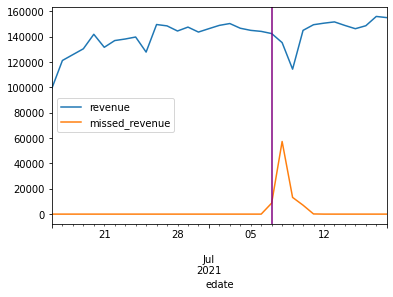

In [326]:
filters = (df.edate >= pd.to_datetime(start_dt)) & (df.edate <= pd.to_datetime(end_dt))
df['potential_revenue'] = df.revenue+df.missed_revenue
df[filters].groupby('edate')['revenue','missed_revenue'].sum().plot()
plt.gca().axvline(x=datetime.datetime(2021,7,7), color = 'purple')

In [338]:
df[filters].pivot_table(values = ['revenue','missed_revenue'], index = 'sponsored_bnd', aggfunc = np.sum, margins = True).sort_values('revenue', ascending = False).style.format('${:,.0f}')